# Data Analysis of Olivocerebellar Model

## Table of Contents
### 1. Import All
    1. Import packages
    2. Import data of simulations
### 2. Split Data - Before/After Adaptation
### 3. Connectivity Graph
### 4. Raster Plots
    1. Single Loop (1PC-10DCN-1IO)
    2. Entire Sytem (10PC-20DCN-20IO)
### x. Purkinje Cell 
    1. Input current
    2. Seperate Input current
### x. Inferior Olive
    1. Spike Time comparisson
### x. Correlations/Delays
    1. IO - IO 
    2. Correlation between inputs
### x. Complex Spike Analysis
    1. PC current input
    2. Voltage of IO cell
    

## 1. Import All

In [1]:
# 1.1) Import packages
import numpy as np
from importlib import reload
from brian2 import*
import pickle
import NeuroTools as nt
from NeuroTools import signals, analysis
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import scipy.io as sio
import seaborn as sns
import matplotlib.patches as mpatches
import elephant.statistics as stat
#import plotpy.express as px
%matplotlib notebook

# Import and reload my helpers module for iterative development
import helpers
reload(helpers)
from helpers.Function_DataAnalysis import *
#from helpers.bin import *

# default dict. to assign values
from collections import defaultdict

# 1.2) Import data of simulations
nameInput = 'Plast_test'
#name_simparam = nameInput + '_SimParams.pickle'

name_VoltCell_STDP = nameInput + '_VoltageCell_Plasticity.pickle'
#name_VoltCell_noSTDP = nameInput + '_VoltageCell_NoPlasticity.pickle'

#name_SpikeT_noSTDP = nameInput + '_SpikeTimes_NoPlasticity.pickle'
name_SpikeT_STDP = nameInput + '_SpikeTimes_Plasticity.pickle'

#name_PV = nameInput + '_PlasticityVariables.pickle'
#name_Input_noSTDP = nameInput + 'AfterSim_NoPlasticity.pickle'
name_Input_STDP = nameInput + 'AfterSim_Plasticity.pickle'

name_PV = nameInput + '_PlasticityVariables.pickle'
with open(name_PV, 'rb') as par:
    PV = pickle.load(par)
#with open(name_SpikeT_noSTDP, 'rb') as st:
#    SpikeTimes_noSTDP = pickle.load(st)
#with open(name_VoltCell_noSTDP, 'rb') as vc:
#    VoltCell_noSTDP = pickle.load(vc)
#with open(name_Input_noSTDP, 'rb') as inp:
#    Input_noSTDP = pickle.load(inp)

with open(name_SpikeT_STDP, 'rb') as stm:
    SpikeTimes_STDP = pickle.load(stm)
with open(name_VoltCell_STDP, 'rb') as vcm:
    VoltCell_STDP = pickle.load(vcm)
with open(name_Input_STDP, 'rb') as inpm:
    Input_STDP = pickle.load(inpm)


## 2. Split Data - Before/After Adaptation

In [11]:
# 2) Split Data - before/after adaptation    

# before = start_t:t_beforeAdaptation
# after = t_beforeAdaptaion:end
# indicated by BA (BeforeAdaptation) and AA (AfterAdaptation) accordingly

start = 0 # remove first second of data due to transient
t_beforeAdaptation = int(len(Input_STDP['I'][1])/2)
#print(len(Input_STDP['I'][1]))
#print(len(Input_noSTDP['I'][1]))
dur_bef=int(max(SpikeTimes_STDP['PC'][1]))+1
print(dur_bef)

nrInputs=Input_STDP['I'].shape[0] # number of inputs
nrPC = VoltCell_STDP['PC'].shape[0]
nrDCN = VoltCell_STDP['DCN'].shape[0]
nrIO = VoltCell_STDP['IOsoma'].shape[0]
nrDummy = nrPC*nrInputs
lengthSim =VoltCell_STDP['PC'].shape[1]


#### NOTE: What to do with 'regular' Input?

# Input to the system
#Input = Slicing(Input_noSTDP, t_start=start)
#Input_BA = Slicing(Input_noSTDP, t_start=start)
Input_AA = Slicing(Input_STDP, t_start=start)

# Voltages of Cells
#VoltCell = Slicing(VoltCell_noSTDP, t_start=start)
#VoltCell_BA = Slicing(VoltCell_noSTDP, t_start=start)
VoltCell_AA = Slicing(VoltCell_STDP, t_start=start)

for k in range(0,nrIO):
    spikeio_aa, _ = find_peaks(VoltCell_STDP['IOsoma'][k], height=0.0, distance = 10) 
    #spikeio_ba, _ = find_peaks(VoltCell_noSTDP['IOsoma'][k], height=0.0, distance = 10) 
    #spikeio_ba = spikeio_ba/1000
    spikeio_aa = spikeio_aa/1000
    #SpikeTimes_noSTDP['IO'][k]=spikeio_ba
    SpikeTimes_STDP['IO'][k]=spikeio_aa

#print(SpikeTimes_noSTDP['IO'])
# Slicing spike times
#SpikeTimes_BA = SlicingSpikes(SpikeTimes_noSTDP, t_start=start/1e3)
SpikeTimes_AA = SlicingSpikes(SpikeTimes_STDP, t_start=start/1e3)
#SpikeTimes = SlicingSpikes(SpikeTimes_noSTDP, t_start=start/1e3)

dur_aft=len(Input_AA['I'][1])
t=np.linspace(start/1e3,dur_bef,dur_aft)
print(t)
#print('1-2.5s',SpikeTimes_BA
#     ,'2.5-5s',SpikeTimes_AA)
#print('1-2.5s input', len(Input_BA['I'][1]),
#     '2.5-5s input', len(Input_AA['I'][1]))
#print('1-26 s spikes io', SpikeTimes_BA['IO'][1],
#     '25-50 s spikes io', SpikeTimes_AA['IO'][1])
print(Input_AA)

5
[0.00000000e+00 1.00020004e-03 2.00040008e-03 ... 4.99799960e+00
 4.99899980e+00 5.00000000e+00]
{'I': [array([0.4       , 0.40251321, 0.40502602, ..., 0.39246196, 0.39497398,
       0.39748679]) * namp, array([0.4       , 0.42506665, 0.44973798, ..., 0.32637509, 0.35026202,
       0.37493335]) * namp], 'nweight': [array([0.52631579, 0.52631579, 0.52706067, ..., 0.52794984, 0.52786595,
       0.52778623]), array([0.47368421, 0.47368421, 0.47442804, ..., 0.4739825 , 0.47393784,
       0.47389585]), array([0.47058824, 0.47058824, 0.47133207, ..., 0.47224521, 0.47215954,
       0.47207812]), array([0.46666667, 0.46666667, 0.46740945, ..., 0.46810717, 0.46803126,
       0.46795914]), array([0.46153846, 0.46231825, 0.4622802 , ..., 0.46296203, 0.46288915,
       0.46354835]), array([0.45454545, 0.45454545, 0.45528824, ..., 0.45663311, 0.4565284 ,
       0.45642885]), array([0.44444444, 0.44522423, 0.44518618, ..., 0.44596374, 0.44588557,
       0.44581129]), array([0.42857143, 0.42857143,

<IPython.core.display.Javascript object>


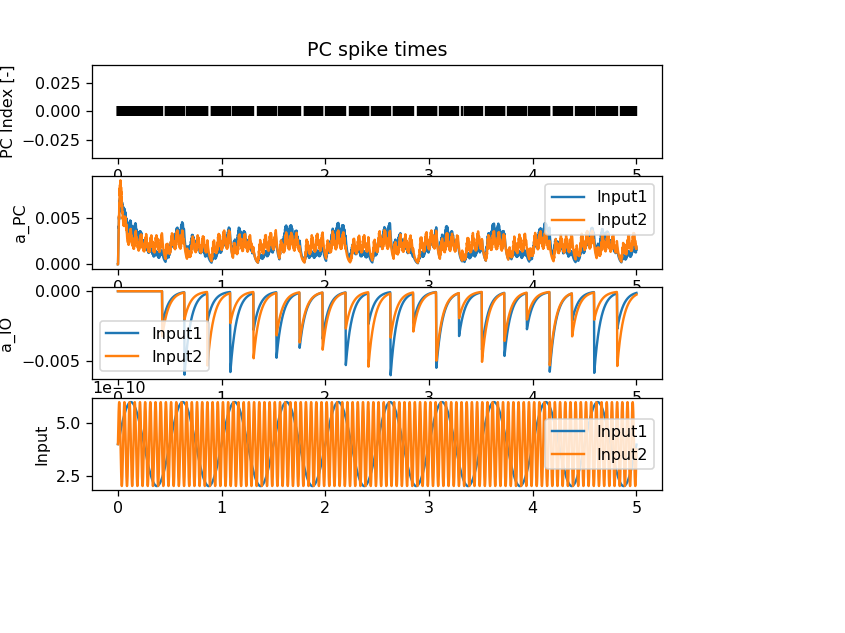

<IPython.core.display.Javascript object>


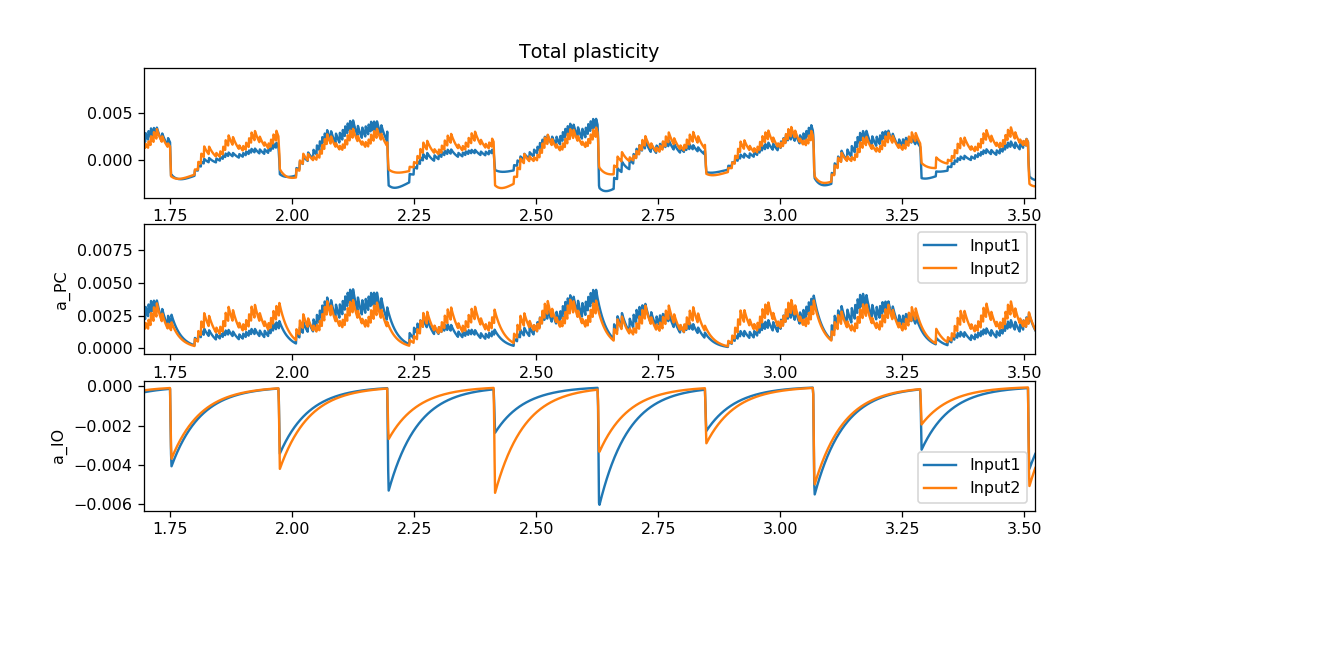

Text(0, 0.5, 'a_IO')

In [22]:
%matplotlib notebook


for yy in range(0,1):
        
    ax1 = plt.subplot(4,1,1)
    plt.title("PC spike times")
    ax1.set_ylabel('PC Index [-]')
    neu = SpikeTimes_AA['PC'][yy]
    lensim = len(neu)
    yPC=np.ones((lensim,1))*yy
    axs=plt.scatter(x=neu,y=yPC,marker='|', color='black', label='PC'+str(yy))

l = len(Input_AA['I_InputPC'][0])
plt.subplot(412,sharex=ax1)
plt.plot(t,PV['a_PC'][0])
plt.plot(t,PV['a_PC'][10])
plt.legend(['Input1','Input2'])
plt.ylabel('a_PC')
plt.subplot(413,sharex=ax1)
plt.plot(t,PV['a_IO'][0])
plt.plot(t,PV['a_IO'][10])
plt.legend(['Input1','Input2'])
plt.ylabel('a_IO')
plt.subplot(414,sharex=ax1)
plt.plot(t,Input_AA['I'][0])
plt.plot(t,Input_AA['I'][1])
plt.legend(['Input1','Input2'])
plt.ylabel('Input')

plt.figure(figsize=(10,5))
ax11=plt.subplot(311)
plt.plot(t,Input_AA['nweight'][0]-0.52631579)
plt.plot(t,Input_AA['nweight'][10]-0.47368421)
plt.title('Total plasticity')
plt.subplot(312,sharex=ax11)
plt.plot(t,PV['a_PC'][0])
plt.plot(t,PV['a_PC'][10])
plt.legend(['Input1','Input2'])
plt.ylabel('a_PC')
plt.subplot(313,sharex=ax11)
plt.plot(t,PV['a_IO'][0])
plt.plot(t,PV['a_IO'][10])
plt.legend(['Input1','Input2'])
plt.ylabel('a_IO')

### 3. Connectivity Graph

In [ ]:
# Connection Graphs

if nrInputs == 5 :
    # Input - Dummy
    i_ind = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
    j_ind = np.arange(nrDummy)
    Connectivity(i_ind,j_ind,'Input','Dummy')

    # Dummy-PC
    i_dPC = np.arange(nrInputs*nrPC)
    j_dPC = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    Connectivity(j_dPC,i_dPC,'PC','Dummy')
    # IO - dummy 
    i_IOd = [9, 10, 18, 17, 0, 6, 5, 12, 16, 11, 9, 10, 18, 17, 0, 6, 5, 12, 16, 11, 9, 10, 18, 17, 0, 6, 5, 12, 16, 11, 9, 10, 18, 17, 0, 6, 5, 12, 16, 11, 9, 10, 18, 17, 0, 6, 5, 12, 16, 11]
    j_IOd=np.arange(nrInputs*nrPC)
    Connectivity(i_IOd,j_IOd,'IO','Dummy')
    # IO - PC
    i_IOPC = [9,10, 18, 17, 0, 6, 5, 12, 16, 11]
    j_IOPC = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    Connectivity(j_IOPC,i_IOPC,'PC','IO')
    # DCN - IO
    i_DCNIO = [0, 0 ,0, 0 ,0,0 ,0, 0,0,0,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,7,7,8,8,8,8,8,8,8,8,8,8,9,9,9,9,9,9,9,9,9,9 ,10 ,10 ,10 ,10 ,10 ,10 ,10 ,10 ,10 ,10 ,11 ,11 ,11 ,11 ,11 ,11 ,11 ,11 ,11 ,11 ,12 ,12 ,12 ,12 ,12 ,12 ,12 ,12 ,12 ,12 ,13 ,13 ,13 ,13 ,13 ,13 ,13 ,13 ,13 ,13 ,14 ,14 ,14 ,14,14 ,14 ,14 ,14 ,14 ,14 ,15 ,15 ,15 ,15 ,15 ,15 ,15 ,15 ,15 ,15 ,16 ,16 ,16 ,16 ,16 ,16 ,16 ,16 ,16 ,16 ,17 ,17 ,17 ,17 ,17 ,17 ,17 ,17 ,17 ,17 ,18 ,18 ,18 ,18 ,18 ,18 ,18 ,18 ,18 ,18 ,19 ,19,19 ,19 ,19 ,19 ,19 ,19 ,19 ,19]
    j_DCNIO = [5 ,7, 10, 15 ,4 ,6 ,9 ,3 ,1, 11 ,8 ,4 ,11, 17, 14 ,9 ,3 ,2 ,0, 15 ,0 ,3 ,7 ,2 ,9 ,10, 19, 17 ,4 ,14 ,2 ,8, 16 ,3 ,5, 19, 12 ,0, 18, 17, 12 ,9 ,6, 10, 13 ,3 ,4 ,2, 15, 18 ,2, 14, 19, 18, 16, 17 ,5 ,8 ,4 ,9, 14 ,6 ,8, 16, 12, 19 ,4 ,5 ,0 ,3, 16 ,9,13 ,1, 17 ,0 ,8, 14 ,7, 10, 10 ,6, 13 ,1 ,4, 18 ,8, 12, 17 ,0 ,7, 11 ,3 ,1 ,9, 10,6, 17, 13, 18 ,8, 16 ,7 ,1 ,6, 12, 10, 19, 15 ,4, 12 ,2 ,4 ,1, 19, 13, 17, 16 ,8 ,9, 12 ,4 ,3 ,1 ,0 ,8 ,2, 11, 14, 13, 10, 17, 12, 13, 16, 11 ,4 ,2 ,8 ,5, 15, 17, 13, 19, 14 ,1 ,4, 16 ,6 ,3 ,5, 16 ,0, 19 ,2 ,9, 18 ,6 ,4 ,1, 10 ,8, 15 ,3 ,0 ,1 ,4, 13, 19 ,7 ,3 ,9, 14, 18, 16, 17 ,5, 19, 11, 10, 11 ,6, 15, 10 ,5, 12, 17 ,4 ,8, 16, 14 ,8,
     10, 15, 4, 11 ,2 ,7 ,5, 18]
    Connectivity(i_DCNIO,j_DCNIO,'DCN','IO')

    # PC - DCN
    i_PCDCN = [0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,2 ,2 ,2 ,2 ,2 ,2 ,2 ,2 ,2 ,2 ,3 ,3 ,3 ,3 ,3 ,3 ,3
     ,3 ,3 ,3 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,5 ,5 ,5 ,5 ,5 ,5 ,5 ,5 ,5 ,5 ,6 ,6 ,6 ,6 ,6 ,6 ,6 ,6 ,6 ,6 ,7 ,7 ,7 ,7
     ,7 ,7 ,7 ,7 ,7 ,7 ,8 ,8 ,8 ,8 ,8 ,8 ,8 ,8 ,8 ,8 ,9 ,9 ,9 ,9 ,9 ,9 ,9 ,9 ,9 ,9]
    j_PCDCN = [15, 10, 18 ,3 ,8 ,7 ,1 ,4, 16 ,2 ,4, 14, 12, 10 ,2, 13 ,3 ,0, 15, 16 ,5 ,9 ,0, 13,14, 11, 15, 17, 16, 10, 16 ,1, 13, 17 ,9 ,3 ,5, 10, 12, 18 ,4, 12, 18 ,2 ,5, 13, 15 ,7 ,1 ,6 ,8, 16, 17 ,1, 13, 12, 15 ,7 ,4 ,2, 17 ,0, 14 ,7 ,3, 19 ,4 ,9 ,5 ,2, 18 ,4 ,0, 11, 15 ,3 ,9 ,1 ,8 ,2 ,19 ,1 ,11, 10 ,6 ,0 ,9, 17, 12 ,3 ,7, 11, 17 ,1 ,2, 14,5 ,4, 12 ,0]
    Connectivity(i_PCDCN,j_PCDCN,'PC','DCN')
elif nrInputs == 2:
    # Input-dummy
    i_ind = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    j_ind = np.arange(nrInputs*nrPC)
    Connectivity(i_ind,j_ind,'Input','Dummy')
    # dummy-PC
    i_dPC = np.arange(nrInputs*nrPC)
    j_dPC = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    Connectivity(j_dPC,i_dPC,'PC','Dummy')

    # IO - dummy
    i_IOd = [9,10, 18, 17, 0, 6, 5, 12, 16, 11, 9,10, 18, 17, 0, 6, 5, 12, 16, 11]
    j_IOd=np.arange(nrInputs*nrPC)
    Connectivity(i_IOd,j_IOd,'IO','Dummy')

    # IO - PC
    i_IOPC = [9,10, 18, 17, 0, 6, 5, 12, 16, 11]
    j_IOPC = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    Connectivity(j_IOPC,i_IOPC,'PC','IO')

    # DCN - IO
    i_DCNIO = [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,7,7,8,8,8,8,8,8,8,8,8,8,9,9,9,9,9,9,9,9,9,9,10,10,10,10,10,10,10,10,10,10,11,11,11,11,11,11,11,11,11,11,12,12,12,12,12,12,12,12,12,12,13,13,13,13,13,13,13,13,13,13,14,14,14,14,14,14,14,14,14,14,15,15,15,15,15,15,15,15,15,15,16,16,16,16,16,16,16,16,16,16,17,17,17,17,17,17,17,17,17,17,18,18,18,18,18,18,18,18,18,18,19,19,19,19,19,19,19,19,19,19]

    j_DCNIO = [11,4,8,9,14,10,1,7,17,6,9,18,1,0,5,3,6,4,13,2,17,15,4,2,10,16,18,13,19,8,10,4,8,6,3,17,2,19,16,11,19,11,15,2,7,8,4,17,10,1,16,12,15,13,3,0,4,11,1,18,11,8,18,17,12,15,2,5,0,6,15,9,6,8,14,4,18,3,19,12,19,4,14,3,1,11,13,8,15,17,14,16,8,9,11,1,17,2,18,19,12,18,19,10,7,2,13,14,4,5,2,8,5,7,0,13,15,18,6,10,16,3,8,15,1,12,4,7,9,2,10,2,8,5,12,19,16,14,15,4,10,17,13,5,0,18,8,15,4,11,5,12,6,4,2,17,19,14,10,3,17,10,1,15,3,4,7,13,5,16,9,3,15,11,12,0,4,5,7,18,18,2,0,3,9,15,13,1,17,8,14,18,17,3,7,8,9,6,5,13]
    Connectivity(i_DCNIO,j_DCNIO,'DCN','IO')

    # PC - DCN
    i_PCDCN = [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,7,7,8,8,8,8,8,8,8,8,8,8,9,9,9,9,9,9,9,9,9,9]
    j_PCDCN = [8,17,13,9,11,14,4,16,1,0,17,5,13,2,3,19,4,7,6,8,15,18,2,8,7,11,0,10,16,17,4,16,19,11,18,7,10,8,5,0,0,17,11,13,3,6,1,8,5,10,19,17,12,15,14,4,8,10,18,11,8,6,1,4,16,5,18,3,2,9,3,9,18,11,14,15,4,17,19,10,6,15,10,5,0,11,9,17,12,2,18,0,3,7,2,16,19,10,5,13]
    Connectivity(i_PCDCN,j_PCDCN,'PC','DCN')


###  4. Raster Plots 
Questions answered:
    1. Does the input modulate the PC?
    2. Does the IO cell modulate the PC?
    3. Is there modulation at the level of the DCN?

In [ ]:

%matplotlib notebook

l = len(Input_BA['I_InputPC'][0])
RasterPlot(SpikeTimes_BA['IO'],SpikeTimes_BA['PC'],SpikeTimes_BA['DCN'],'no',l)
RasterPlot(SpikeTimes_AA['IO'],SpikeTimes_AA['PC'],SpikeTimes_AA['DCN'],'no',l)
RasterPlot(SpikeTimes_BA['IO'][9],SpikeTimes_BA['PC'][0],SpikeTimes_BA['DCN'],'yes',l,Input_BA['I_InputPC'][0])
RasterPlot(SpikeTimes_AA['IO'][9],SpikeTimes_AA['PC'][0],SpikeTimes_AA['DCN'],'yes',l,Input_BA['I_InputPC'][0])

### 3. Purkinje Cell

In [ ]:
# 3.1 Input current 

InputCurrentPC={}
InputCurrentPC_BA={}
InputCurrentPC_AA={}
print(size(Input_AA['nweight'],0))
for i in range(0,nrPC):
    # Create names for the inputs
    name = 'PC'+str(i)
    nameBA = 'PC'+str(i) + 'BA'
    nameAA = 'PC'+str(i) + 'AA'
    
    weightBA = 'WeightPC'+str(i)+'BA'
    weightAA = 'WeightPC'+str(i)+'AA'

    tot = name + 'total'
    totBA = nameBA + 'total'
    totAA = nameAA + 'total'
    # Connectivity between PC-dummy
    steps =np.arange(i,nrDummy,nrPC)
    #print(steps)
    # Multiply the current times the weight
    #current = [Input['I'][k]*Input['nweight'][steps[k]] for k in range(0,len(steps))]
    #currentBA = [Input_BA['I'][k]*Input_BA['nweight'][steps[k]] for k in range(0,len(steps))]
    weight_BA = [Input_BA['nweight'][steps[k]] for k in range(0,len(steps))]
    weight_AA = [Input_AA['nweight'][steps[k]] for k in range(0,len(steps))]
    
    currentBA = [Input_BA['I'][k]*Input_BA['nweight'][steps[k]] for k in range(0,len(steps))]
    currentAA = [Input_AA['I'][k]*Input_AA['nweight'][steps[k]] for k in range(0,len(steps))]
    #[Input_s.nweight_BA[steps[k]]*Input_s.I_BA[k] for k in range(0,len(steps))]
    #print(steps[1])
    #print(size(Input_s.nweight_BA[0]))
    #print(size(current))
    # Sum over the column to get the total amount of current
    #summedcurrent = sum(current,axis=0)
    summedcurrentBA = sum(currentBA, axis=0)
    summedcurrentAA = sum(currentAA, axis=0)
    
    #InputCurrentPC[name] = current
    InputCurrentPC_BA[nameBA] = currentBA
    InputCurrentPC_AA[nameAA] = currentAA
    
    # weights seperate
    InputCurrentPC_BA[weightBA] = weight_BA
    InputCurrentPC_AA[weightAA] = weight_AA
    
    #InputCurrentPC[tot] = summedcurrent
    InputCurrentPC_BA[totBA] = summedcurrentBA
    InputCurrentPC_AA[totAA] = summedcurrentAA
    
print(InputCurrentPC_BA['WeightPC0BA'])    
#for k in range(0,nrPC):
#    figure() 
#    title('PC'+str(k)+'input current')
#    nameBA= 'PC'+str(k)+'BA'
#    nameAA= 'PC'+str(k)+'AA'
#    for i in range(0,nrInputs):
#        subplot(nrInputs,1,i+1)
#        plot(InputCurrentPC_BA[nameBA][i])
#        plot(InputCurrentPC_AA[nameAA][i])
#        #subplot(nrInputs,1,i+1)
#    figure()
#    for i in range(0,nrInputs):
#        subplot(nrInputs,1,i+1)
#        plot(Input_BA['nweight'][k+i])
#        axvline(SpikeTimes_BA[connectionVector[k]])
#        plot(Input_AA['nweight'][k+i])

#print(size(InputCurrentPC_BA['PC1BA'],0))


In [ ]:
%matplotlib notebook
plt.figure()
plt.plot(InputCurrentPC_AA['WeightPC0AA'][0])    
plt.show()

### 4. IO Cell

In [ ]:
# 4.1 Spike time comparisson
import matplotlib.colors as colors
import matplotlib.cm as cmx

NCURVES=nrIO
values = range(NCURVES)
jet = get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=values[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
ionam=[]
figure(figsize=(10,5))
for kk in range(0,nrIO):
    ioname = 'IO' + str(kk)
    spikio_BA = SpikeTimes_BA['IO'][kk]
    
    nr =  len(spikio_BA)   
    colorVal = scalarMap.to_rgba(values[kk])
    
    mm = scatter(x=where(spikio_BA==spikio_BA), y=spikio_BA, marker='.', color=colorVal)
    #for uu in range(0,nr):
    #    scatter(x=where(spikio_BA==spikio_BA[uu]),y=spikio_BA[uu],marker=".", color=colorVal)
    ionam.append(ioname)
xlabel('number of spikes before adaptation[-]',fontsize=15)
ylabel('spike times [s]',fontsize=15)
legend(ionam, fontsize=15)
show()

figure(figsize=(10,5))
for yy in range(0,nrIO):
    ioname = 'IO' + str(yy)
    spikio_BA = SpikeTimes_AA['IO'][yy]
    
    nr =  len(spikio_BA)   
    colorVal = scalarMap.to_rgba(values[yy])
    
    mm = scatter(x=where(spikio_BA==spikio_BA), y=spikio_BA, marker='.', color=colorVal)
    #for uu in range(0,nr):
    #    scatter(x=where(spikio_BA==spikio_BA[uu]),y=spikio_BA[uu],marker=".", color=colorVal)
    ionam.append(ioname)
xlabel('number of spikes after adaptation [-]',fontsize=15)
ylabel('spike times [s]', fontsize=15)
legend(ionam, fontsize=15)
show()

        

### 5. Correlations

In [ ]:
# 5.2 Correlation between inputs

corr_BA_Inputs = np.empty((nrPC,nrInputs))
corr_AA_Inputs = np.empty((nrPC,nrInputs))

for k in range(0,nrPC):
    namePC_BA = 'PC'+str(k)+'BA'
    namePC_AA = 'PC'+str(k)+'AA'

    
    corr_InputPC_BA = [np.corrcoef(Input_BA['I_InputPC'][k],InputCurrentPC_BA[namePC_BA][p]) for p in range(0,nrInputs)]
    corr_InputPC_AA = [np.corrcoef(Input_AA['I_InputPC'][k],InputCurrentPC_AA[namePC_AA][p]) for p in range(0,nrInputs)]


    for p in range(0,len(corr_InputPC_BA)):
        corr_BA_Inputs[k,p]=corr_InputPC_BA[p][0,1]
        corr_AA_Inputs[k,p] = corr_InputPC_AA[p][0,1]

    #print('correlation coefficient AA',corr_InputPC_AA)
    #print('correlation coefficient BA',corr_InputPC_BA)
#print(corr_BA_Inputs)
#print(corr_AA_Inputs)
#print(corr_BA_Inputs-corr_AA_Inputs)
#figure()
#plot(InputCurrentPC_BA['PC0BA'][0])
figure()
ylabel=['Input PC'+str(k) for k in range(0,nrPC)]
nf = sns.heatmap(corr_BA_Inputs,center=0, cmap='jet', linewidths=.5, 
                 xticklabels=['low frequency','high frequency'],yticklabels=ylabel,
                 annot=True)
figure()
ylabel=['Input PC'+str(k) for k in range(0,nrPC)]
nf = sns.heatmap(corr_AA_Inputs,center=0, cmap='jet', linewidths=.5, 
                 xticklabels=['low frequency','high frequency'],yticklabels=ylabel,
                 annot=True)
#nf.set_xtickslabels()

### 6. Complex Spike Analysis

In [ ]:
# 6.1 Input Current Purkinje Cell
# Get the current that the Purkinje cell sees 150 ms before and 50 ms after
# a complex spike of the connected Inferior Olive

# The IO cells that are connected to the Purkinje cells. 
# Position 1 of the vector corresponds to PC1, 2 to PC2 etc.
connectionVectorIO = [9,10, 18, 17, 0, 6, 5, 12, 16, 11]

time_before_spike = 200e-3
time_after_spike = 200e-3
CS_currentPC=defaultdict(dict)
duration = int((time_before_spike+time_after_spike)*1e3)

#print(dur)
meancur_BA=np.zeros((nrPC,duration))
meancur_AA=np.zeros((nrPC,duration))

sep_curBA=np.zeros((nrPC*2,duration))
sep_curAA=np.zeros((nrPC*2,duration))

mean_voltIO_AA = np.zeros((nrPC,duration))
mean_voltIO_BA = np.zeros((nrPC,duration))

weight_BA = np.zeros((nrInputs*nrPC,duration))
weight_AA = np.zeros((nrInputs*nrPC,duration))

InpPCBA = Input_BA['I_InputPC']
InpPCAA = Input_AA['I_InputPC']
#print(InpPCBA)
#print(InpPCAA)

#print(InpPC)
for jj in range(0,nrPC):
    strp = str(connectionVectorIO[jj])
    pcnr = 'PC'+str(jj)+'BA'
    pcnr2 = 'PC'+str(jj)+'AA'
    w_pcnr = 'WeightPC'+str(jj)+'BA'
    w2_pcnr = 'WeightPC'+str(jj)+'AA'
    #SpikesIO = SpikeTimes_s.ionr
    
    # Input current I_Noise to PC
    InputCurrBA = InpPCBA[jj]
    InputCurrAA = InpPCAA[jj]
    
    # Seperate Inputs (after weight multiplication)
    sep_inpba=InputCurrentPC_BA[pcnr]
    sep_inpaa=InputCurrentPC_AA[pcnr2]
    
    # Get weights 
    sep_wBA =InputCurrentPC_BA[w_pcnr]
    sep_wAA = InputCurrentPC_AA[w2_pcnr]
    # Membrane potential of IO cells
    voltIO_BA = VoltCell_BA['IOsoma'][connectionVectorIO[jj]]
    voltIO_AA = VoltCell_AA['IOsoma'][connectionVectorIO[jj]]
    
    #print(InputCurrBA, sep_inpba)
    #print(sep_inpba[1])
    #InputCurrentPC[pcnr]
    #VoltPC = VoltCell_['PC'][jj]
    #print(VoltPC)
    
    CS_BA= SpikeTimes_BA['IO'][connectionVectorIO[jj]]
    CS_AA = SpikeTimes_AA['IO'][connectionVectorIO[jj]]
    
    # initialization of empty array which are assigned in the loop below
    empt_BA =np.zeros((len(CS_BA),duration))
    empt_AA =np.zeros((len(CS_AA),duration))
    empt_curBA =np.zeros((len(CS_BA)*nrInputs,duration))
    empt_curAA =np.zeros((len(CS_AA)*nrInputs,duration))
    empt_membIO_BA = np.zeros((len(CS_BA),duration))
    empt_membIO_AA = np.zeros((len(CS_AA),duration))
    
    empt_wAA = np.zeros((len(CS_AA)*nrInputs,duration))
    empt_wBA = np.zeros((len(CS_BA)*nrInputs,duration))

    k=0
    for ii in range(0,len(CS_BA)):
        begin_analysis = max(int(((CS_BA[ii]-time_before_spike)/1e-3)),CS_BA[0]*1000)-start
        end_analysis = (int((min((CS_BA[ii]+time_after_spike)/1e-3,
                        CS_BA[-1]*1000))))-start
        #print('before adding', end_analysis-begin_analysis)
        if end_analysis-begin_analysis==duration-1 : 
            end_analysis=end_analysis+1
        elif end_analysis-begin_analysis==duration+1 : 
            end_analysis=end_analysis-1
        #print('after adding', end_analysis-begin_analysis)
        
        
        if (end_analysis-abs(begin_analysis))==duration :
            #CS_currentPC[ionr][ii] = InputCurr[begin_analysis:end_analysis]
            empt_BA[ii]= InputCurrBA[begin_analysis:end_analysis]
            
            # Individual inputs to the PC
            for t in range(0,nrInputs):
                empt_wBA[ii*2+t] = sep_wBA[t][begin_analysis:end_analysis]
                empt_curBA[ii*2+t]=sep_inpba[t][begin_analysis:end_analysis]
                
            
            # IO membrane potential 
            empt_membIO_BA[ii] = voltIO_BA[begin_analysis:end_analysis]
            
            
            #empt_curBA[1+ii*2]=sep_inpba[1][begin_analysis:end_analysis]
            #print(empt_curBA[ii*2])
            #print('got here',empt_curBA)
            #empt_VBA[ii]=VoltPC[begin_analysis:end_analysis]
        else:
            lopl=2+1
            #print(end_analysis-begin_analysis)
            #print('too short')
        #print(empt_curBA[ii*2+t])
        #print('empt cur ba',empt_curBA)
    #print(len(CS_AA))
    for kk in range(0,len(CS_AA)):
        begin_analysis = max(int(((CS_AA[kk]-time_before_spike)/1e-3)),CS_AA[0]*1e3)-t_beforeAdaptation
        #print('begin analysis', begin_analysis)
        end_analysis = int((min((CS_AA[kk]+time_after_spike)/1e-3,
                        CS_AA[-1]*1000)))-t_beforeAdaptation
        #print('end analysis', end_analysis)
        #print(end_analysis-begin_analysis)
        if end_analysis-begin_analysis==duration-1 : 
            end_analysis=end_analysis+1
        elif end_analysis-begin_analysis==duration+1 : 
            end_analysis=end_analysis-1
            
        if (end_analysis-abs(begin_analysis))==duration :
            #print('got there')
            #CS_currentPC[ionr][kk] = InputCurr[begin_analysis:end_analysis]
            #print('aa begin', begin_analysis, 'end aa', end_analysis)
            empt_AA[kk]= InputCurrAA[begin_analysis:end_analysis] 
            
            # get the individual inputs to the PC
            for tt in range(0,nrInputs):
                empt_curAA[kk*2+tt]=sep_inpaa[tt][begin_analysis:end_analysis]
                empt_wAA[kk*2+tt] = sep_wAA[tt][begin_analysis:end_analysis]

            
            # IO membrane potential
            empt_membIO_AA[kk] = voltIO_AA[begin_analysis:end_analysis]
        
            
        else:
            p=9
            #print(end_analysis-begin_analysis)
            #print('too short')

    #print(empt_curBA)                
                #print('not full time - too close to beginning')
    #print('shape_BA',empt_BA.shape)
    #print('shape AA',empt_AA.shape)
    
    # remove zeros - still present when the scope around CS is too large (e.g. CS at 0.2s and try to look at +/-0.3)
    empt_BA = empt_BA[~all(empt_BA==0, axis=1)]
    empt_AA = empt_AA[~all(empt_AA==0, axis=1)]
    
    empt_curAA=empt_curAA[~all(empt_curAA==0, axis=1)]
    empt_curBA=empt_curBA[~all(empt_curBA==0, axis=1)]
    
    empt_membIO_AA=empt_membIO_AA[~all(empt_membIO_AA==0,axis=1)]
    empt_membIO_BA=empt_membIO_BA[~all(empt_membIO_BA==0,axis=1)]
    
    empt_wAA=empt_wAA[~all(empt_wAA==0,axis=1)]
    empt_wBA=empt_wBA[~all(empt_wBA==0,axis=1)]
    
    #print(empt_membIO_AA)
    #print('empt cur after remove 0',empt_curBA.shape[0], 'nr cs ba', len(CS_BA),'times got there', k)
    #print(empt_curBA.shape[0])
    #empt_VBA = empt_VBA[~all(empt_VBA==0, axis=1)]
    #empt_VAA = empt_VAA[~all(empt_VAA==0, axis=1)]
    #print('AA =',empt_AA)
    #print('BA = ',empt_BA)
    #empt=argwhere(empt)
    #print(empt)
    meancur_BA[jj] = mean(empt_BA,axis=0)
    meancur_AA[jj] = mean(empt_AA,axis=0)
    p = [arange(0,empt_curBA.shape[0],2),arange(1,empt_curBA.shape[0],2)]
    pp = [arange(0,empt_curAA.shape[0],2),arange(1,empt_curAA.shape[0],2)]
    #pp = arange(1,empt_curBA.shape[0],2)
    #print('p',p,'pp=',pp)
    for uu in range(0,nrInputs):
        sep_curBA[jj*2+uu] = mean(empt_curBA[p[uu]], axis=0)
        sep_curAA[jj*2+uu] = mean(empt_curAA[pp[uu]], axis=0)
        
        weight_BA[jj*2+uu] = mean(empt_wBA[p[uu]],axis=0)
        weight_AA[jj*2+uu] = mean(empt_wAA[pp[uu]],axis=0)
        
    
    mean_voltIO_AA[jj] = mean(empt_membIO_AA,axis=0)
    mean_voltIO_BA[jj] = mean(empt_membIO_BA,axis=0)
print(mean_voltIO_BA.shape[0])
print(mean_voltIO_AA.shape[0])

    #sep_curAA[jj*2,jj*2+1] = mean(empt_curAA,axis=0)
#print(sep_curBA.shape[0])
#print(sep_curAA.shape[0])
    #meancur_VBA[jj] =mean(empt_VBA,axis=0)
    #meancur_VAA[jj] =mean(empt_VAA,axis=0)
#print(k)
    #print('mean input current =',mean(empt,axis=0))


In [ ]:
# 6.2 Spike Times PC before/after CS
%matplotlib notebook

#SpikesPC_BA=np.zeros((nrPC,dur))
#SpikesPC_AA=np.zeros((nrPC,dur))
figure()
for ii in range(0,nrPC):
    CS_BA= SpikeTimes_BA['IO'][connectionVectorIO[ii]]
    CS_AA = SpikeTimes_AA['IO'][connectionVectorIO[ii]]
    #PC_Spikes = SpikeTimes_BA['PC'][ii]
    
  
    spikesBA = SpikeTimes_BA['PC'][ii]
    spikesIOBA = SpikeTimes_BA['IO'][connectionVectorIO[ii]]
    
    spikesAA = SpikeTimes_AA['PC'][ii]
    spikesIOAA = SpikeTimes_AA['IO'][connectionVectorIO[ii]]      

    lensim = len(spikesBA)
    lensimBA = np.ones((len(spikesIOBA),1))*ii
    yPC=np.ones((lensim,1))*ii    

    lensimm = len(spikesAA)
    lensimAA=np.ones((len(spikesIOAA),1))*ii
    yPC2=np.ones((lensimm,1))*ii    

    subplot(211)
    title('No Plasticity')
    #ylabel('PC index [-]')
    axs=scatter(x=spikesBA,y=yPC,marker='|', color='black', label='PC'+str(ii))
    axs=scatter(x=spikesIOBA,y=lensimBA,marker='|',color='r')
    subplot(212)
    title('Plasticity')
    xlabel('times [s]')
    #ylabel('PC index [-]')
    axs=scatter(x=spikesAA,y=yPC2,marker='|', color='black', label='PC'+str(ii))
    axs=scatter(x=spikesIOAA,y=lensimAA,marker='|',color='r')
show()

### x.2 Membrane potential IO at CS

In [ ]:
# x.2 Plot the average membrane potential of the IO cells around the CS
time = linspace(start=-time_before_spike*1e3,stop=time_after_spike*1e3,num=duration)

big_picture='yes'
for i in range(0,nrPC):
    
    if big_picture=='yes':
        plt.figure()
        #for k in range(0,2):
        #subplot(2,1,1)
        plt.title('Average Membrane Potential IO'+str(connectionVectorIO[i])+' BA (top) AA(botom)')
        plt.plot(time,mean_voltIO_BA[i])
        #subplot(2,1,2)
        #title('Average Membrane Potential IO'+str(connectionVectorIO[i])+' AA')
        plt.plot(time,mean_voltIO_AA[i])
        plt.xlabel('times [ms] - CS at 0')
        plt.ylabel('membrane potential [V]')
        plt.ylim([-0.075,-0.04])
        plt.legend(['before adaptation', 'after adaptation'])

In [ ]:
fig, axs = subplots(5, 2,figsize=(10,5))
p=q=0
#figure(figsize=(20,20))
#fig(figsize=(20,10))
for i in range(0,len(meancur_BA)):
    #subplot(5,2,i+1)
    axs[p,q].plot(time,meancur_BA[i], color='cyan')
    axs[p,q].plot(time,meancur_AA[i], color='black')

    #print(meancur_AA[i])
    #plot(time,meancur_BA[i], color='cyan')
    #plot(time,meancur_AA[i],color='black')
    axs[p,q].axvline(0, linewidth=2,color='r')
    axs[p,q].set_title('Mean input current to PC' + str(i))
    p=p+1
    if i==4:
        q=q+1
        p=0
    for ax in axs.flat:
        ax.set(xlabel='time [ms]', ylabel='current [A]')
    for ax in axs.flat:
        ax.label_outer()
    #axs.figsize((20,10))
legend(['before','after','cs'], loc='lower left')
show()


#fig2, axs2 = subplots(5, 2,figsize=(20,10))
#p=q=0
#for i in range(0,len(meancur_VBA)):
    #subplot(5,2,i+1)
 #   axs2[p,q].plot(time,meancur_VBA[i], color='cyan')
  #  axs2[p,q].plot(time,meancur_VAA[i], color='black')
   # axs2[p,q].axvline(0, linewidth=2,color='r')
    #print(meancur_AA[i])
    #plot(time,meancur_BA[i], color='cyan')
    #plot(time,meancur_AA[i],color='black')
    #axs2[p,q].axvline(0, linewidth=2,color='r')
    #axs2[p,q].set_title('Mean voltage of PC' + str(i))
    #p=p+1
    #if i==4:
    #    q=q+1
    #    p=0
    #for ax in axs2.flat:
    #    ax.set(xlabel='time [ms]', ylabel='Voltage [V]')
    #for ax in axs2.flat:
    #    ax.label_outer()
    #axs.figsize((20,10))
#legend(['before','after','cs'], loc='lower left')
#show()

### x. Frequency plots

In [ ]:
for l in range(0,nrIO):
    if l<10:
        sPC=VoltCell['PC'][l]
        
    sIO=VoltCell['IOsoma'][l]
    sDCN=VoltCell['DCN'][l]
    specPC=FreqSpectrum(sPC)
    specIO=FreqSpectrum(sIO)
    specDCN=FreqSpectrum(sDCN)
    #spec = np.absolute(np.fft.fft(k))
    #leng = int(len(k)/2)
    #spec = spec[:leng]
    #spec /= len(k)  # normalize
    #spec *= 2.0  # to get amplitudes of sine components, need to multiply by 2
    #spec[0] /= 2.0  # except for the dc component
    subplot(311)
    plot(specPC)
    xlabel('frequency')
    #ylabel('amplitude')
    ylim([0,0.002])

    subplot(312)
    plot(specIO)
    xlabel('ferquency')
    #ylabel('amplitude')  
    ylim([0,0.01])

    subplot(313)
    plot(specDCN)
    xlabel('ferquency')
    #ylabel('amplitude')    
    ylim([0,0.002])
show()
    

## .x Spike Raster Plot

In [ ]:
p=int(nrDummy/2)
#print(t)
pc = 2
for k in range(0,pc):
    
    plt.subplot(pc,1,k+1)
    if k==0:
        plt.title('PC 1-'+str(pc)+' weight change inputs')
    ax1=plt.plot(Input_AA['nweight'][k]-np.ones(len(Input_AA['nweight'][k]))*Input_BA['nweight'][k][0])
    ax2=plt.plot(Input_AA['nweight'][k+10]-np.ones(len(Input_AA['nweight'][k+10]))*Input_BA['nweight'][k+10][0])
    print('input 1:',k, 'input 2:',k+10)
    #print('input 2',k+10)
    #plt.plot(Input_BA['nweight'][k])



In [ ]:
%matplotlib notebook
plt.figure()
for i in range(0,nrInputs):
    plt.plot(Input_noSTDP['I'][i])
plt.xlabel('time [ms]')
plt.ylabel('Input current [A]')
#show()
plt.figure()
for i in range(0,nrInputs):
    plt.plot(Input_STDP['I_InputPC'][i])
#plot(InputCurrentPC_AA['PC1AA'][1])
plt.xlabel('time [ms]')
plt.ylabel('Input current [A]')
print(Input_noSTDP['I'])
print(Input_STDP['I'])
plt.show()

In [ ]:
#rolling mean of weights?

In [ ]:
# Correlation between total input and seperate
def corr(x,y):
    #print(asarray(x)-asarray(y))
    return exp(-(((asarray(x)-asarray(y))/1e-9)**2))

# 'yes' to see if the total combined current is equal to the sum of the seperate ones
sanity_check = 'no'  
weight_plot = 'no'
for i in range(0,nrPC):
    #print('mean cur ba',meancur_BA[i])
    #print('sep inp ba 1',sep_curBA[0])
    #print('sep inp ba 1',sep_curBA[1])
    
    bacor=[corr(meancur_BA[i],sep_curBA[i*2+k]) for k in range(0,nrInputs)]
    #print('cor1',bacor[1],'cor0',bacor[0])
    #print(meancur_BA[i]*1e9)
    #print(meancur_AA[i]*1e9)
    #print(sep_curBA[0]*1e9)
    #print(sep_curBA[1]*1e9)
    aacor=[corr(meancur_AA[i],sep_curAA[i*2+k]) for k in range(0,nrInputs)]
    #print(x)
    if weight_plot == 'yes':
        fig, axs = subplots(2, 2,figsize=(10,5),sharex=True)

        #title('Sanity check that seperate inputs combine make total input')
        ax1 = subplot(2,2,1)
        ax1.set_title('Weights changes of input PC' + str(i))
        ax1.plot(weight_BA[i*2+0],label='low f')
        ax1.legend(['low freq BA'])
        ax2=subplot(223)
        ax2.plot(weight_BA[i*2+1],label='high f')
        ax2.legend(['high freq BA'])
        #axs=Axes(label=['low freq','high freq'])
        ax3=subplot(222)
        ax3.plot(weight_AA[i*2+0])
        ax3.plot(weight_BA[i*2+0],label='high f')

        ax3.legend(['low freq AA','low freq BA'])

        ax4 = subplot(224)
        ax4.plot(weight_AA[i*2+1])
        ax4.plot(weight_BA[i*2+1])
        ax4.legend(['high freq AA','high freq BA'])
        
        
    if sanity_check == 'yes':
        fig, axs = subplots(3, 2,figsize=(10,5),sharex=True)

        #title('Sanity check that seperate inputs combine make total input')
        ax1 = subplot(3,2,1)
        ax1.set_title('Sanity Check- sep inputs added = total input BA' + str(i))
        ax1.plot(meancur_BA[i])
        ax2=subplot(323)
        ax2.plot(sep_curBA[i*2+0],label='low f')
        ax2.plot(sep_curBA[i*2+1],label='high f')
        ax2.legend(['low freq','high freq'])
        #axs=Axes(label=['low freq','high freq'])
        ax3=subplot(325)
        ax3.plot(sep_curBA[i*2+0]+sep_curBA[i*2+1])
        ax3.plot(meancur_BA[i])
        
        #figure(figsize=(10,5))
        #title('Sanity check that seperate inputs combine make total input')
        ax4 = subplot(322)
        ax4.plot(meancur_AA[i])
        ax5=subplot(324)
        ax5.plot(sep_curAA[i*2+0])
        ax5.plot(sep_curAA[i*2+1])
        ax5.legend(['low freq','high freq'])
        #set_labels(['low freq','high freq'])
        ax6=subplot(326)
        ax6.plot(sep_curAA[i*2+0]+sep_curAA[i*2+1])
        ax6.plot(meancur_AA[i])
    
    figa, axsa = subplots(nrInputs,2)
    title('Correlation of the inputs with the total input BA')
    for oo in range(0,nrInputs):
        ax1a = subplot(nrInputs,2,oo*2+1)
        ax1a.set_title('BA signal'+str(oo))
        ax1a.plot(time,bacor[oo])
        xxx=float32(max(bacor[oo]))
        print(min(bacor[oo]),max(bacor[oo]))
        ax1a.set_ylim(min(bacor[oo]),xxx)
            #[min(bacor[oo]),max(bacor[oo])])

        #ylim([min(bacor[oo]),max(bacor[oo])])
        ax2a = subplot(nrInputs,2,oo*2+2)
        ax2a.set_title('AA signal'+str(oo))
        ax2a.plot(time,aacor[oo])
        ax2a.set_ylim(min(aacor[oo]),max(aacor[oo]))
        
            #[min(aacor[oo]),max(aacor[oo])])
        #ylim([min(aacor[oo]),max(aacor[oo])])

    
    #figure()
    #title('Correlation of the inputs with total input AA')
    #for ee in range(0,nrInputs):
    #    subplot(nrInputs,1,ee+1)
    #    plot(time,aacor[ee])
    


In [ ]:
weight =[0.52631579,0.47368421, 0.47058824, 0.46666667, 0.46153846, 0.45454545,
 0.44444444, 0.42857143, 0.4,        0.33333333, 0.47368421, 0.52631579,
 0.52941176, 0.53333333, 0.53846154 ,0.54545455, 0.55555556, 0.57142857,
 0.6 ,       0.66666667]
inp1=weight[0:10]
print(inp1)
inp2=weight[10:]
print(inp2)
inpmean=np.empty((10,1))
print(inpmean)
for k in range(0,len(inp2)):
    inpmean[k] = inp1[k]+inp2[k]
print(inpmean)
print(np.mean(inpmean,axis=1))
print(np.mean(inp1))
print(np.mean(inp2))

In [ ]:
#from elephant import spike_train_correlation as stc
#from elephant.spike_train_correlation import CrossCorrHist
import helpers
reload(helpers)
from helpers.Function_DataAnalysis import *
%matplotlib notebook
import elephant.conversion as conv
import neo as n
import quantities as pq
import elephant.spike_train_correlation as stcorr
import warnings

# Call Correlation Plot function 
# CorrelationPlot(Spikes, nrNeurons, nr of bins, vis)

# spikes : {Dict} - with list of spikes
# nrNeurons : int - number of neurons
# nr of bins : int - number of bins in which the spikes are divided
# vis :  str - 'yes' or 'no' to visualization
# corr1 : np.array - what cells number you want to correlate with the other

# returns - nr x nr matrix delays

sIO_BA = SpikeTimes_BA['IO']
sIO_AA = SpikeTimes_AA['IO']
bins=25001

#corr=np.arange(0,20,1)
#print(corr)
#for k in corr:
#    print(k)
delayBA = CorrelationPlot(sIO_BA,nrIO, bins,'no')
delayAA = CorrelationPlot(sIO_AA,nrIO, bins,'no')


In [ ]:
figure()
nf = sns.heatmap(delayBA, cmap='jet',center=0, linewidths=.5)
figure()
pf = sns.heatmap(delayAA, cmap='jet',center=0, linewidths=.5)

In [ ]:
import numpy as np
from numpy import sin, pi, exp
import scipy.integrate as integrate


#t= np.linspace(0,10,100)
t0=100e-3
tau=1
alpha=0.005
beta = -0.1
k= exp(-(t-t0)/tau)*sin(2*pi*(t-t0)/tau)**20
#deltaweight = integrate.quad(lambda t: k, -inf,3)
#**20

plt.figure()
plt.plot(t,k)
plt.show()